<a href="https://colab.research.google.com/github/liubruce11/BA820-TeamB7/blob/emily-pet-cats/M2_Emily_Su_Q3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **BA820 Project M2 EDA**

**Pet Cats UKs**

Team B7: Emily Su

# **0. Research Question (Q3)**

**Question:** To what extent are apparent differences in cats’ movement behavior genuine behavioral variation, versus artifacts introduced by uneven GPS tracking density across individuals?

#**1. Setup**

In [1]:
# import packages
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# pulls dataset
url1 = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/refs/heads/main/data/2023/2023-01-31/cats_uk.csv"

cats_uk = pd.read_csv(url1)

url2 = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/refs/heads/main/data/2023/2023-01-31/cats_uk_reference.csv"

cats_uk_ref = pd.read_csv(url2)

In [3]:
cats_uk.head()

,tag_id,event_id,visible,timestamp,location_long,location_lat,ground_speed,height_above_ellipsoid,algorithm_marked_outlier,manually_marked_outlier,study_name
0,Ares,3395610551,True,2017-06-24T01:03:57Z,-5.113851,50.170315,684,154.67,False,False,Pet Cats United Kingdom
1,Ares,3395610552,True,2017-06-24T01:11:20Z,-5.113851,50.170315,936,154.67,False,False,Pet Cats United Kingdom
2,Ares,3395610553,True,2017-06-24T02:58:16Z,-5.113730,50.169876,2340,81.35,False,False,Pet Cats United Kingdom
3,Ares,3395610554,True,2017-06-24T03:01:26Z,-5.113774,50.169827,0,67.82,False,False,Pet Cats United Kingdom
4,Ares,3395610555,True,2017-06-24T03:51:58Z,-5.114247,50.170139,4896,118.03,False,False,Pet Cats United Kingdom


In [4]:
cats_uk_ref.head()

,tag_id,animal_id,animal_taxon,deploy_on_date,deploy_off_date,hunt,prey_p_month,animal_reproductive_condition,animal_sex,hrs_indoors,n_cats,food_dry,food_wet,food_other,study_site,age_years
0,Tommy-Tag,Tommy,Felis catus,2017-06-03T01:02:09Z,2017-06-10T02:10:52Z,True,12.5,Neutered,m,12.5,2,True,True,False,UK,11.0
1,Athena,Athena,Felis catus,2017-06-24T01:02:13Z,2017-06-30T23:59:32Z,True,3.0,Spayed,f,7.5,2,True,True,False,UK,3.0
2,Ares,Ares,Felis catus,2017-06-24T01:03:57Z,2017-06-30T23:58:01Z,NaN,0.0,Neutered,m,7.5,2,True,True,False,UK,3.0
3,Lola,Lola,Felis catus,2017-06-24T01:18:49Z,2017-06-30T09:04:40Z,True,3.0,Spayed,f,17.5,1,True,True,False,UK,10.0
4,Maverick,Maverick,Felis catus,2017-06-25T01:04:35Z,2017-07-03T09:10:07Z,True,3.0,Neutered,m,12.5,1,True,True,True,UK,7.0


In [5]:
cats_uk_clean = cats_uk.dropna(subset=["timestamp", "location_lat", "location_long"]).copy()

## Orginal EDA

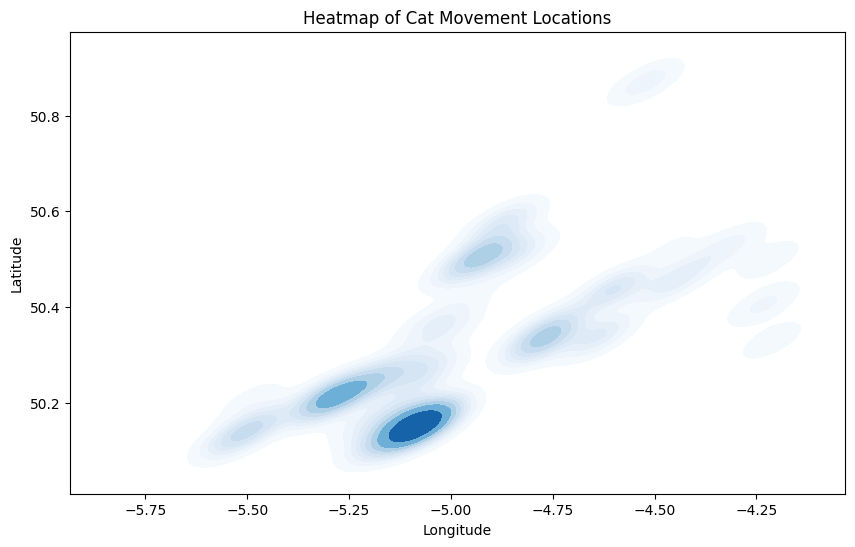

In [30]:
plt.figure(figsize=(10, 6))
sns.kdeplot(x=cats_uk['location_long'], y=cats_uk['location_lat'], cmap='Blues', fill=True)
plt.title("Heatmap of Cat Movement Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


# **2. Construct Per-Cat Movement Features**

In [8]:
cats_uk_clean = cats_uk_clean.copy()

cats_uk_clean["timestamp"] = pd.to_datetime(cats_uk_clean["timestamp"], utc=True, errors="coerce")

for col in ["location_long", "location_lat", "ground_speed"]:
    if col in cats_uk_clean.columns:
        cats_uk_clean[col] = pd.to_numeric(cats_uk_clean[col], errors="coerce")

cats_uk_clean = cats_uk_clean.dropna(subset=["tag_id", "timestamp", "location_long", "location_lat"]).copy()

# sort step distances
cats_uk_sorted = cats_uk_clean.sort_values(["tag_id", "timestamp"]).copy()

# previous point per cat
cats_uk_sorted["prev_lon"] = cats_uk_sorted.groupby("tag_id")["location_long"].shift(1)
cats_uk_sorted["prev_lat"] = cats_uk_sorted.groupby("tag_id")["location_lat"].shift(1)

R = 6371.0

lon1 = np.radians(cats_uk_sorted["prev_lon"].to_numpy(dtype=float))
lat1 = np.radians(cats_uk_sorted["prev_lat"].to_numpy(dtype=float))
lon2 = np.radians(cats_uk_sorted["location_long"].to_numpy(dtype=float))
lat2 = np.radians(cats_uk_sorted["location_lat"].to_numpy(dtype=float))

dlon = lon2 - lon1
dlat = lat2 - lat1

a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
c = 2 * np.arcsin(np.sqrt(a))

cats_uk_sorted["step_km"] = np.nan_to_num(R * c, nan=0.0)

# aggregate per cat
cat_feats = cats_uk_sorted.groupby("tag_id").agg(
    n_points=("event_id", "count"),
    start_time=("timestamp", "min"),
    end_time=("timestamp", "max"),
    lon_min=("location_long", "min"),
    lon_max=("location_long", "max"),
    lat_min=("location_lat", "min"),
    lat_max=("location_lat", "max"),
    lon_std=("location_long", "std"),
    lat_std=("location_lat", "std"),
    total_dist_km=("step_km", "sum"),
    mean_step_km=("step_km", "mean"),
    median_step_km=("step_km", "median"),
    max_step_km=("step_km", "max"),
    mean_speed=("ground_speed", "mean"),
).reset_index()

# ensure data are datetimes
cat_feats["start_time"] = pd.to_datetime(cat_feats["start_time"], utc=True, errors="coerce")
cat_feats["end_time"] = pd.to_datetime(cat_feats["end_time"], utc=True, errors="coerce")

cat_feats["duration_hours"] = (cat_feats["end_time"] - cat_feats["start_time"]).dt.total_seconds() / 3600.0
cat_feats["bbox_lon_range"] = cat_feats["lon_max"] - cat_feats["lon_min"]
cat_feats["bbox_lat_range"] = cat_feats["lat_max"] - cat_feats["lat_min"]
cat_feats["bbox_area_deg2"] = cat_feats["bbox_lon_range"] * cat_feats["bbox_lat_range"]

# density-aware feature refinements
cat_feats["dist_per_point_km"] = cat_feats["total_dist_km"] / cat_feats["n_points"].clip(lower=1)
cat_feats["dist_per_hour_km"] = cat_feats["total_dist_km"] / cat_feats["duration_hours"].replace(0, np.nan)
cat_feats["bbox_area_per_point"] = cat_feats["bbox_area_deg2"] / cat_feats["n_points"].clip(lower=1)

cat_feats.head()


,tag_id,n_points,start_time,end_time,lon_min,lon_max,lat_min,lat_max,lon_std,lat_std,...,median_step_km,max_step_km,mean_speed,duration_hours,bbox_lon_range,bbox_lat_range,bbox_area_deg2,dist_per_point_km,dist_per_hour_km,bbox_area_per_point
0,Abba-Tag,83,2017-09-25 01:19:26+00:00,2017-10-02 11:04:58+00:00,-5.205609,-5.194827,50.160252,50.164215,0.001146,0.000407,...,0.031920,0.773246,1603.951807,177.758889,0.010782,0.003963,0.000043,0.050884,0.023759,5.148080e-07
1,Alfie-Tag,187,2017-10-23 01:03:54+00:00,2017-10-30 10:20:43+00:00,-4.763076,-4.750526,50.341965,50.346031,0.001753,0.000870,...,0.040967,0.782164,1931.679144,177.280278,0.012550,0.004066,0.000051,0.058499,0.061706,2.728786e-07
2,Amber-Tag,218,2017-07-28 01:03:24+00:00,2017-08-04 00:07:52+00:00,-4.673843,-4.633688,50.311447,50.341736,0.002686,0.002057,...,0.043872,4.238906,1967.614679,167.074444,0.040155,0.030289,0.001216,0.085391,0.111419,5.579150e-06
3,Ares,103,2017-06-24 01:03:57+00:00,2017-06-30 23:58:01+00:00,-5.116042,-5.112664,50.169136,50.171623,0.000569,0.000353,...,0.037044,0.150643,2285.825243,166.901111,0.003378,0.002487,0.000008,0.040206,0.024812,8.156394e-08
4,Athena,106,2017-06-24 01:02:13+00:00,2017-06-30 23:59:32+00:00,-5.114899,-5.110911,50.168354,50.170673,0.000416,0.000247,...,0.021505,0.316049,2134.188679,166.955278,0.003988,0.002319,0.000009,0.031645,0.020091,8.724691e-08


In [9]:
cat_level = cat_feats.merge(cats_uk_ref, on="tag_id", how="left")
cat_level[["tag_id","n_points","total_dist_km","bbox_area_deg2","dist_per_point_km","hrs_indoors","prey_p_month"]].head()


,tag_id,n_points,total_dist_km,bbox_area_deg2,dist_per_point_km,hrs_indoors,prey_p_month
0,Abba-Tag,83,4.223395,0.000043,0.050884,7.5,3.0
1,Alfie-Tag,187,10.939235,0.000051,0.058499,7.5,3.0
2,Amber-Tag,218,18.615289,0.001216,0.085391,7.5,3.0
3,Ares,103,4.141184,0.000008,0.040206,7.5,0.0
4,Athena,106,3.354355,0.000009,0.031645,7.5,3.0


# **3. Density Diagnostics**

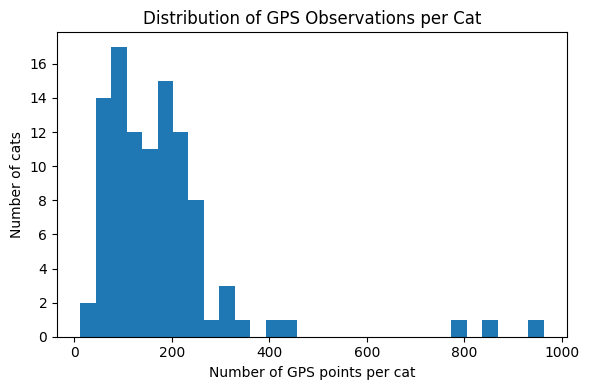

,0
tag_id,
Gracie_2-Tag,963
Bits-Tag,867
Teddy-Tag,791
Ginge-Tag,445
Maxwell-Tag,404
Tom-Tag,360
Bella-Tag,318
Jago2-Tag,307
Lightening Bugg-Tag,302


In [31]:
points_per_cat = cats_uk_clean.groupby("tag_id").size().sort_values(ascending=False)

plt.figure(figsize=(6,4))
plt.hist(points_per_cat, bins=30)
plt.xlabel("Number of GPS points per cat")
plt.ylabel("Number of cats")
plt.title("Distribution of GPS Observations per Cat")
plt.tight_layout()
plt.show()

points_per_cat.head(10)


- GPS tracking density varies substantially across cats, with a small number of individuals contributing disproportionately many observations. This imbalance suggests that raw movement summaries may not be directly comparable across individuals.

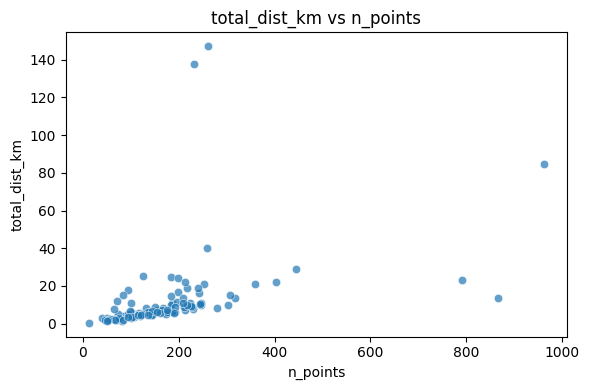

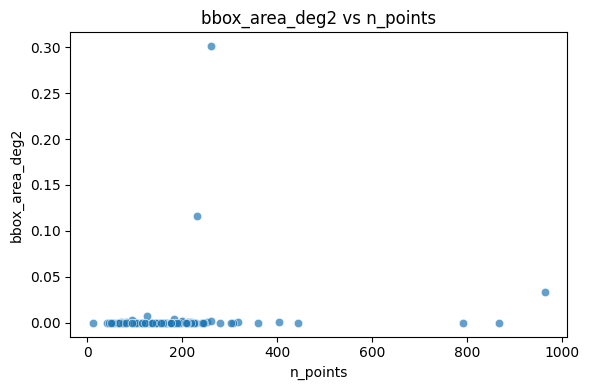

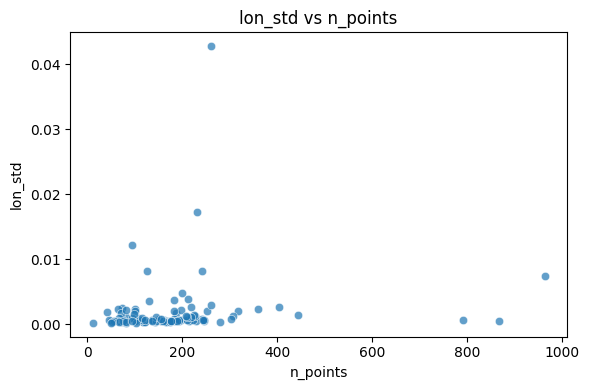

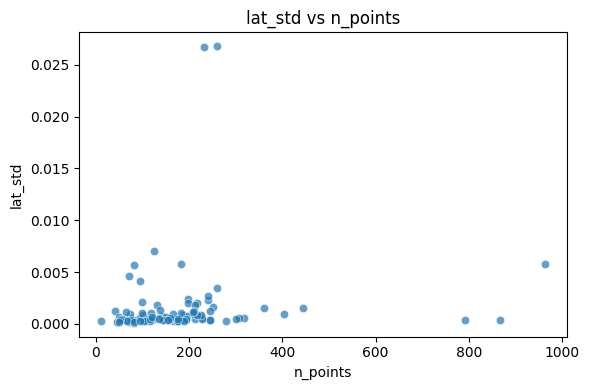

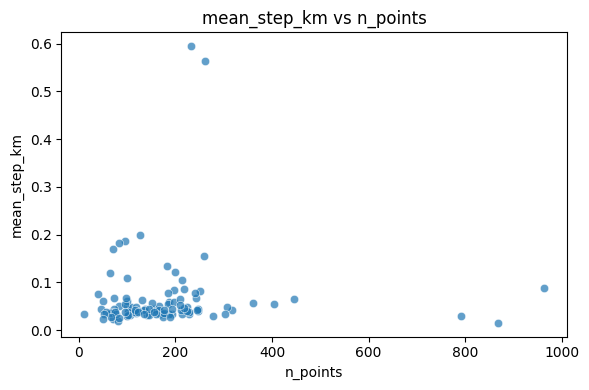

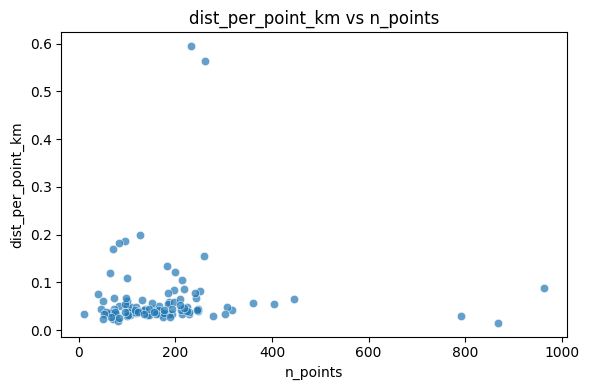

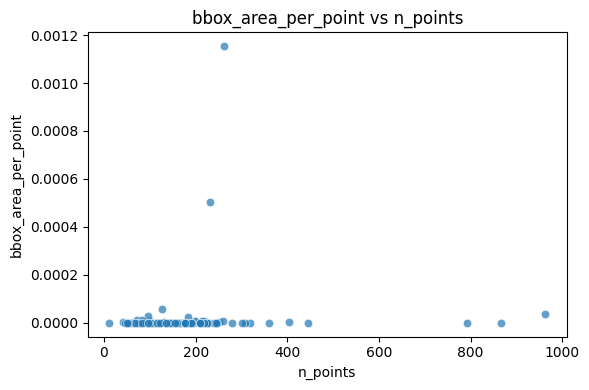

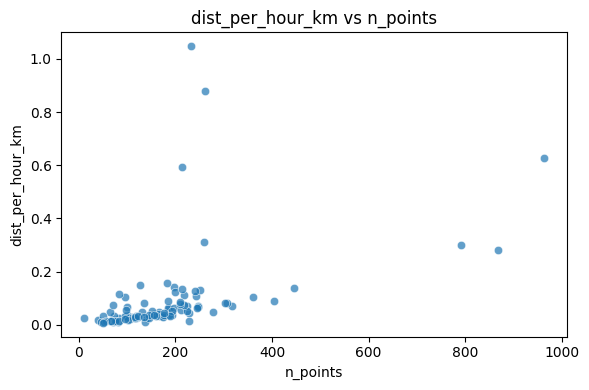

In [10]:
raw_features = ["total_dist_km", "bbox_area_deg2", "lon_std", "lat_std"]
norm_features = ["mean_step_km", "dist_per_point_km", "bbox_area_per_point", "dist_per_hour_km"]

for col in raw_features + norm_features:
    plt.figure(figsize=(6,4))
    sns.scatterplot(data=cat_level, x="n_points", y=col, alpha=0.7)
    plt.title(f"{col} vs n_points")
    plt.tight_layout()
    plt.show()


- Raw movement features scale strongly with tracking density, while density-aware features show reduced—but not eliminated—dependence on observation count.

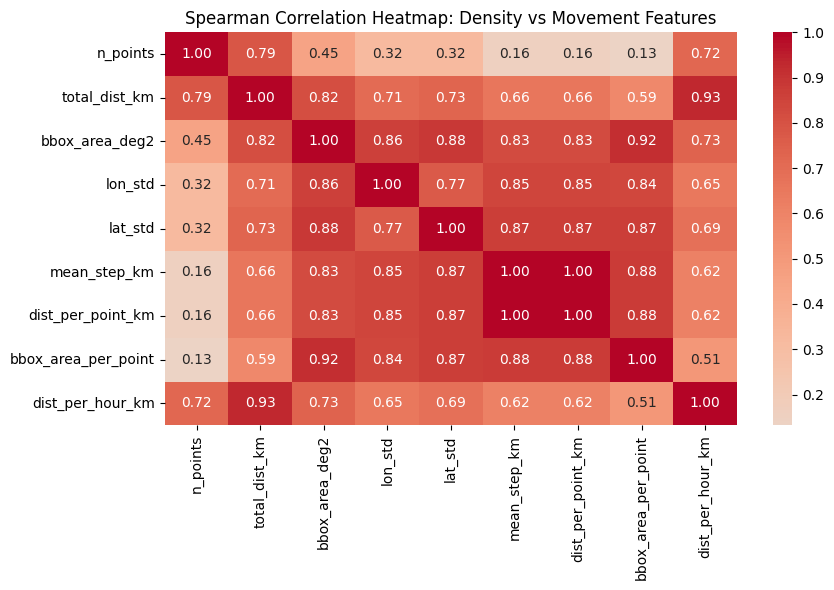

In [11]:
heat_cols = ["n_points"] + raw_features + norm_features
corr = cat_level[heat_cols].corr(method="spearman")

plt.figure(figsize=(9,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Spearman Correlation Heatmap: Density vs Movement Features")
plt.tight_layout()
plt.show()


- High correlations between tracking density and several movement features further suggest that measurement intensity is a dominant driver of apparent variation.

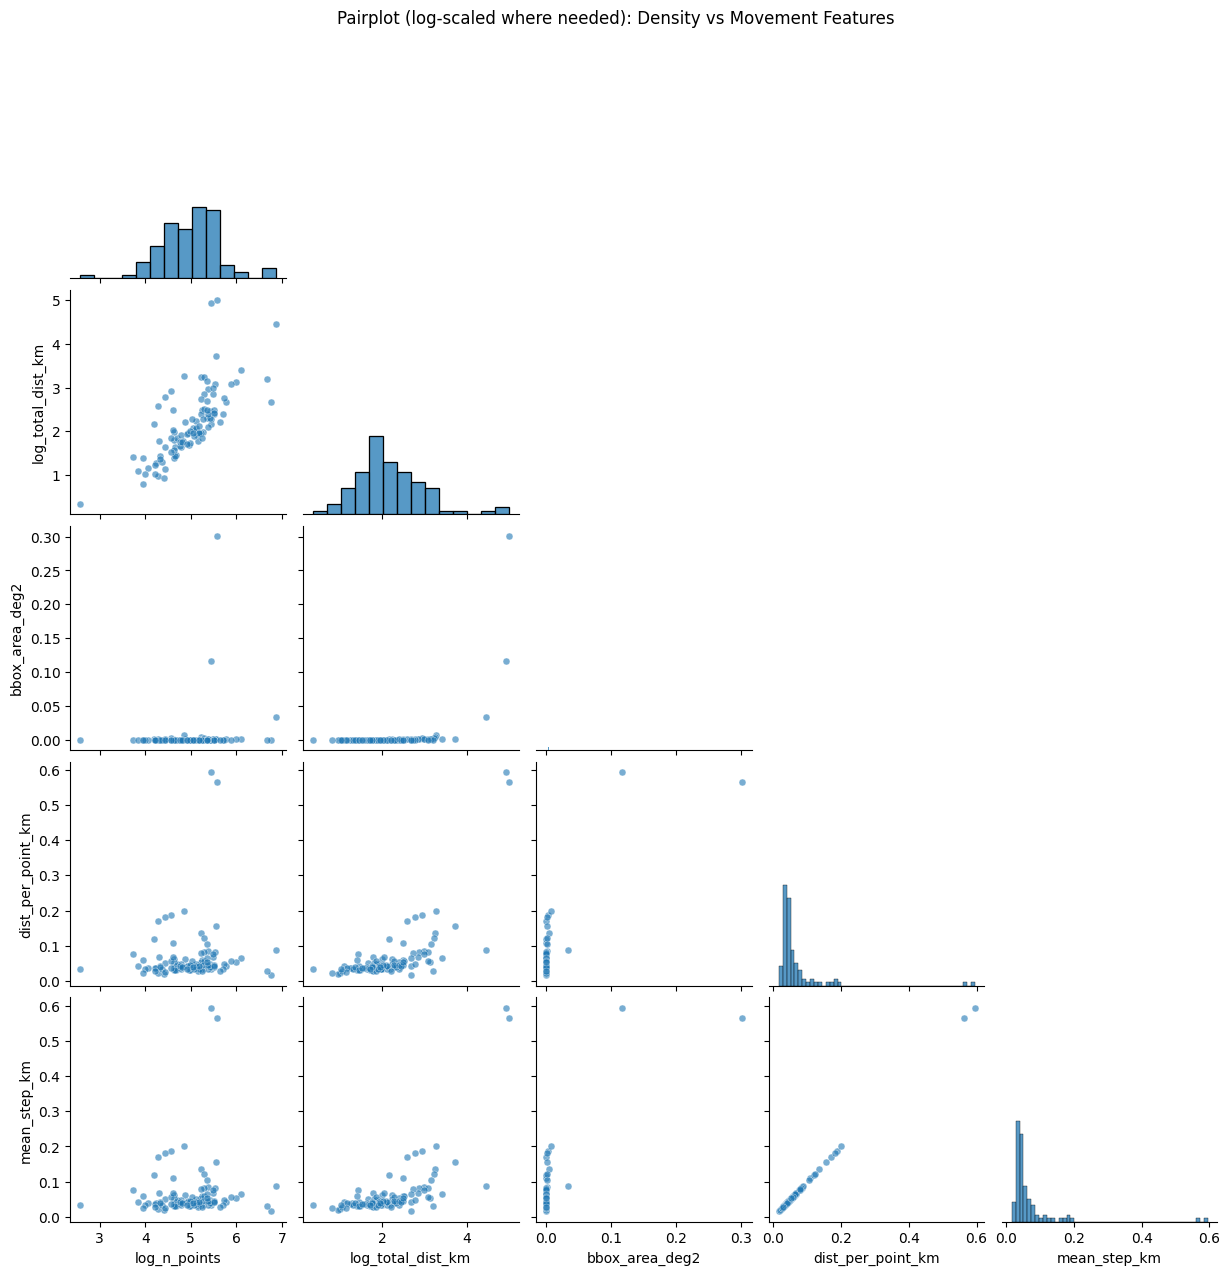

In [12]:
pair_df = cat_level[["n_points", "total_dist_km", "bbox_area_deg2", "dist_per_point_km", "mean_step_km"]].dropna()

pair_df = pair_df.copy()
pair_df["log_n_points"] = np.log1p(pair_df["n_points"])
pair_df["log_total_dist_km"] = np.log1p(pair_df["total_dist_km"])

sns.pairplot(pair_df[["log_n_points", "log_total_dist_km", "bbox_area_deg2", "dist_per_point_km", "mean_step_km"]],
             corner=True, plot_kws={"alpha": 0.6, "s": 25})
plt.suptitle("Pairplot (log-scaled where needed): Density vs Movement Features", y=1.02)
plt.show()


# **4. PCA: RAW vs Density-Aware**

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


### Choose feature sets

In [14]:
# Raw - density-sensitive features
raw_pca_features = ["total_dist_km", "bbox_area_deg2", "lon_std", "lat_std"]

# Normalized - density-aware features
norm_pca_features = ["dist_per_point_km", "bbox_area_per_point", "mean_step_km", "dist_per_hour_km"]

missing_raw = [c for c in raw_pca_features if c not in cat_level.columns]
missing_norm = [c for c in norm_pca_features if c not in cat_level.columns]
print("Missing raw columns:", missing_raw)
print("Missing norm columns:", missing_norm)


Missing raw columns: []
Missing norm columns: []


### Prepare PCA input matrices

In [15]:
X_raw_df = cat_level[raw_pca_features].copy()
X_norm_df = cat_level[norm_pca_features].copy()

raw_mask = X_raw_df.notna().all(axis=1)
norm_mask = X_norm_df.notna().all(axis=1)

X_raw_df = X_raw_df.loc[raw_mask]
X_norm_df = X_norm_df.loc[norm_mask]

# match metadata for plotting (n_points + tag_id)
meta_raw = cat_level.loc[raw_mask, ["tag_id", "n_points"]].copy()
meta_norm = cat_level.loc[norm_mask, ["tag_id", "n_points"]].copy()

print("Cats used in RAW PCA:", X_raw_df.shape[0])
print("Cats used in NORM PCA:", X_norm_df.shape[0])


Cats used in RAW PCA: 101
Cats used in NORM PCA: 101


### Standardized features

In [16]:
scaler_raw = StandardScaler()
X_raw_scaled = scaler_raw.fit_transform(X_raw_df)

scaler_norm = StandardScaler()
X_norm_scaled = scaler_norm.fit_transform(X_norm_df)


### Fit PCA

In [17]:
# on rawfeatures
pca_raw = PCA(n_components=min(6, X_raw_scaled.shape[1]))
raw_scores = pca_raw.fit_transform(X_raw_scaled)

# on normalized features
pca_norm = PCA(n_components=min(6, X_norm_scaled.shape[1]))
norm_scores = pca_norm.fit_transform(X_norm_scaled)

print("RAW explained variance ratio:", np.round(pca_raw.explained_variance_ratio_, 3))
print("NORM explained variance ratio:", np.round(pca_norm.explained_variance_ratio_, 3))



RAW explained variance ratio: [0.918 0.051 0.016 0.015]
NORM explained variance ratio: [0.876 0.073 0.051 0.   ]


### Plot

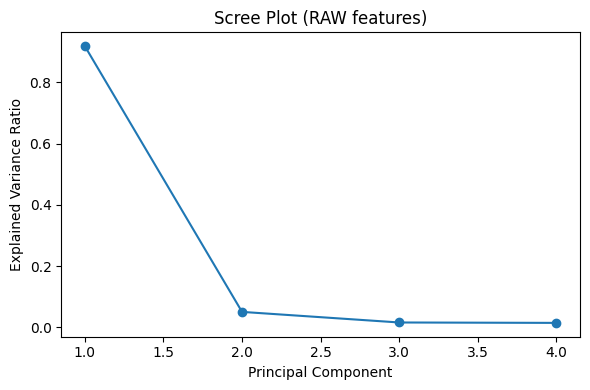

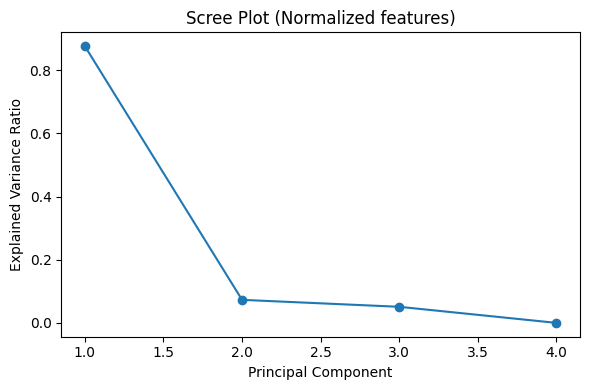

In [18]:
plt.figure(figsize=(6,4))
plt.plot(range(1, len(pca_raw.explained_variance_ratio_)+1),
         pca_raw.explained_variance_ratio_, marker="o")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot (RAW features)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(range(1, len(pca_norm.explained_variance_ratio_)+1),
         pca_norm.explained_variance_ratio_, marker="o")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot (Normalized features)")
plt.tight_layout()
plt.show()


- **RAW Scree** The first principal component explains ~92% of the total variance, indicating that raw movement summaries largely collapse onto a single dominant dimension. This suggests that apparent behavioral variation is driven by a common factor rather than multiple distinct movement patterns.

- Normalized Scree Plot** Using density-aware features modestly redistributes variance across components, but PC1 still explains the majority of variation (~88%). This indicates that normalization reduces, but does not eliminate, the dominance of a single movement dimension.

### Plot PC1 vs PC2

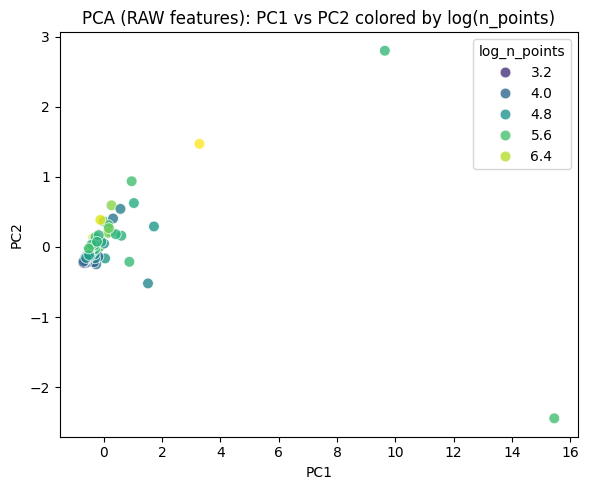

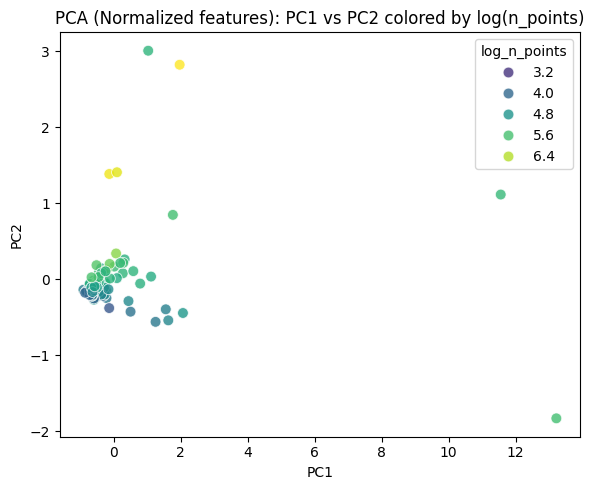

In [19]:
# RAW PCA plot
raw_plot = pd.DataFrame(raw_scores[:, :2], columns=["PC1", "PC2"])
raw_plot["tag_id"] = meta_raw["tag_id"].values
raw_plot["n_points"] = meta_raw["n_points"].values
raw_plot["log_n_points"] = np.log1p(raw_plot["n_points"])

plt.figure(figsize=(6,5))
sns.scatterplot(data=raw_plot, x="PC1", y="PC2", hue="log_n_points", palette="viridis", s=60, alpha=0.8)
plt.title("PCA (RAW features): PC1 vs PC2 colored by log(n_points)")
plt.tight_layout()
plt.show()

# NORMALIZED PCA plot
norm_plot = pd.DataFrame(norm_scores[:, :2], columns=["PC1", "PC2"])
norm_plot["tag_id"] = meta_norm["tag_id"].values
norm_plot["n_points"] = meta_norm["n_points"].values
norm_plot["log_n_points"] = np.log1p(norm_plot["n_points"])

plt.figure(figsize=(6,5))
sns.scatterplot(data=norm_plot, x="PC1", y="PC2", hue="log_n_points", palette="viridis", s=60, alpha=0.8)
plt.title("PCA (Normalized features): PC1 vs PC2 colored by log(n_points)")
plt.tight_layout()
plt.show()


- **RAW PCA: PC1 vs PC2 (colored by log(n_points))**

Cats with higher GPS tracking density occupy more extreme positions along PC1, showing that the dominant variance direction is strongly aligned with observation intensity. Apparent “outliers” in the raw PCA space are therefore more likely to reflect denser data collection than fundamentally different movement behavior.

- **Normalized PCA: PC1 vs PC2 (colored by log(n_points))**

Compared to the raw feature space, the normalized PCA shows weaker alignment between PC1 and tracking density, suggesting improved comparability across cats. However, the structure remains continuous rather than forming distinct clusters, indicating limited evidence for discrete behavioral types at this level of aggregation.

### PCA loadings

In [20]:
raw_loadings = pd.DataFrame(
    pca_raw.components_.T,
    index=raw_pca_features,
    columns=[f"PC{i}" for i in range(1, pca_raw.n_components_+1)]
)
norm_loadings = pd.DataFrame(
    pca_norm.components_.T,
    index=norm_pca_features,
    columns=[f"PC{i}" for i in range(1, pca_norm.n_components_+1)]
)

print("RAW loadings (PC1/PC2):")
display(raw_loadings[["PC1","PC2"]].sort_values("PC1", ascending=False))

print("NORM loadings (PC1/PC2):")
display(norm_loadings[["PC1","PC2"]].sort_values("PC1", ascending=False))


RAW loadings (PC1/PC2):


,PC1,PC2
lat_std,0.503514,0.396021
lon_std,0.502152,-0.447137
bbox_area_deg2,0.498423,-0.539759
total_dist_km,0.495874,0.593209


NORM loadings (PC1/PC2):


,PC1,PC2
mean_step_km,0.520615,-0.199077
dist_per_point_km,0.520615,-0.199077
bbox_area_per_point,0.486535,-0.411782
dist_per_hour_km,0.470324,0.866702


In [21]:
raw_pc1_density = pd.DataFrame({
    "PC1": raw_plot["PC1"],
    "log_n_points": raw_plot["log_n_points"]
}).corr(method="spearman").loc["PC1","log_n_points"]

norm_pc1_density = pd.DataFrame({
    "PC1": norm_plot["PC1"],
    "log_n_points": norm_plot["log_n_points"]
}).corr(method="spearman").loc["PC1","log_n_points"]

print("Spearman corr(PC1, log_n_points) — RAW:", round(raw_pc1_density, 3))
print("Spearman corr(PC1, log_n_points) — NORM:", round(norm_pc1_density, 3))


Spearman corr(PC1, log_n_points) — RAW: 0.578
Spearman corr(PC1, log_n_points) — NORM: 0.405


- **RAW PCA:** PC1 loads nearly equally on spatial dispersion (lat_std, lon_std, bbox_area_deg2) and cumulative distance (total_dist_km), indicating a dominant “overall movement magnitude” dimension rather than distinct behaviors.

- **Density influence:** PC1 remains moderately correlated with tracking density (Spearman ρ = 0.578), suggesting measurement intensity strongly shapes apparent variation.

- **Normalized PCA:** PC1 reflects average movement intensity (mean_step_km, dist_per_point_km) with reduced dependence on density (ρ = 0.405).

- **Secondary structure:** PC2 in the normalized PCA is dominated by time-normalized movement (dist_per_hour_km), separating temporal activity from spatial scale.

- **Overall takeaway:** Normalization improves interpretability but does not reveal clearly separable behavioral types.

# **5. Clustering**

In [22]:
from sklearn.cluster import KMeans

In [23]:
# Use only the first two PCs
X_pca = norm_scores[:, :2]


### K-means (k = 2)

In [24]:
kmeans_2 = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters_2 = kmeans_2.fit_predict(X_pca)

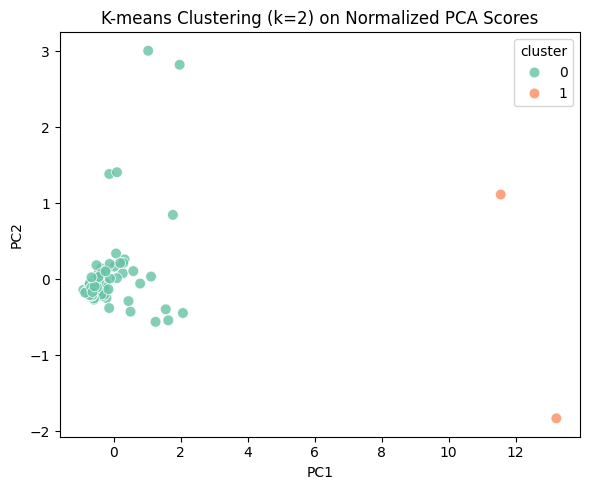

In [25]:
cluster_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
cluster_df["cluster"] = clusters_2
cluster_df["n_points"] = meta_norm["n_points"].values
cluster_df["log_n_points"] = np.log1p(cluster_df["n_points"])

plt.figure(figsize=(6,5))
sns.scatterplot(
    data=cluster_df,
    x="PC1", y="PC2",
    hue="cluster",
    palette="Set2",
    s=60, alpha=0.8
)
plt.title("K-means Clustering (k=2) on Normalized PCA Scores")
plt.tight_layout()
plt.show()


In [26]:
cluster_df.groupby("cluster")[["n_points"]].mean()


,n_points
cluster,
0,179.010101
1,246.500000


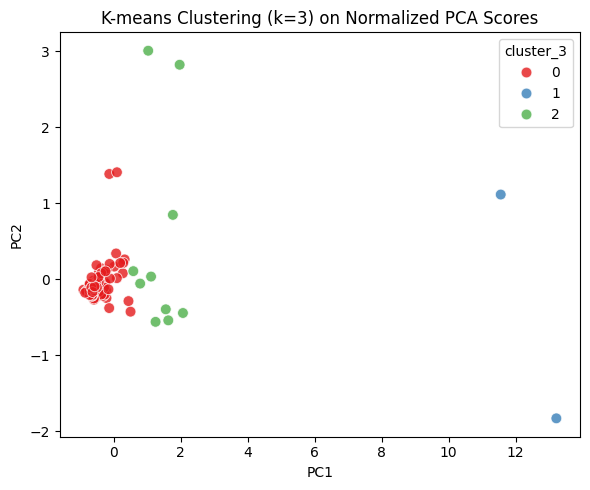

In [27]:
kmeans_3 = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters_3 = kmeans_3.fit_predict(X_pca)

cluster_df["cluster_3"] = clusters_3

plt.figure(figsize=(6,5))
sns.scatterplot(
    data=cluster_df,
    x="PC1", y="PC2",
    hue="cluster_3",
    palette="Set1",
    s=60, alpha=0.8
)
plt.title("K-means Clustering (k=3) on Normalized PCA Scores")
plt.tight_layout()
plt.show()


In [32]:
cluster_df.groupby("cluster_3")[["n_points"]].mean()

,n_points
cluster_3,
0,172.067416
1,246.500000
2,240.800000


- Clustering primarily isolates a small number of extreme, densely tracked cats, reinforcing the conclusion that residual structure remains density-driven.

# **6. Key Takeaways + Next Step**



*   Apparent movement heterogeneity is strongly influenced by GPS sampling density

* Density-aware features improve comparability but do not reveal clear behavioral clusters

* PCA is a necessary diagnostic step before attempting behavioral segmentation

